<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/LayoutLMv2/RVL-CDIP/Fine_tuning_LayoutLMv2ForSequenceClassification_on_RVL_CDIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we are going to fine-tune `LayoutLMv2ForSequenceClassification` on the [RVL-CDIP](https://www.cs.cmu.edu/~aharley/rvl-cdip/#:~:text=The%20RVL%2DCDIP%20(Ryerson%20Vision,images%2C%20and%2040%2C000%20test%20images.) dataset, which is a document image classification task. Each scanned document in the dataset belongs to one of 16 classes, such as "resume" or "invoice" (so it's a multiclass classification problem). The entire dataset consists of no less than 400,000 (!) scanned documents.

For demonstration purposes, we are going to fine-tune the model on a really small subset (one example per class), and verify whether the model is able to overfit them. Note that LayoutLM achieves state-of-the-art results on RVL-CDIP, with a classification accuracy of 94.42% on the test set.

* Original LayoutLMv2 paper: https://arxiv.org/abs/2012.14740

## Setting up environment

We install HuggingFace Transformers and Detectron2.

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 50 kB 4.5 MB/s 
     |████████████████████████████████| 636 kB 16.1 MB/s 
     |████████████████████████████████| 895 kB 54.0 MB/s 
     |████████████████████████████████| 3.3 MB 53.2 MB/s 


In [2]:
!pip install -q pyyaml==5.1
# workaround: install old version of pytorch since detectron2 hasn't released packages for pytorch 1.9 (issue: https://github.com/facebookresearch/detectron2/issues/3158)
!pip install -q torch==1.8.0+cu101 torchvision==0.9.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

# install detectron2 that matches pytorch 1.8
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
#!pip install -q detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
!python -m pip install -q 'git+https://github.com/facebookresearch/detectron2.git'

     |████████████████████████████████| 274 kB 8.2 MB/s 
     |████████████████████████████████| 763.5 MB 15 kB/s 
     |████████████████████████████████| 17.3 MB 290 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.10.0 requires torch==1.9.0, but you have torch 1.8.0+cu101 which is incompatible.
     |████████████████████████████████| 49 kB 3.7 MB/s 
     |████████████████████████████████| 74 kB 4.3 MB/s 
     |████████████████████████████████| 145 kB 73.1 MB/s 
     |████████████████████████████████| 130 kB 74.5 MB/s 
     |████████████████████████████████| 745 kB 55.3 MB/s 
     |████████████████████████████████| 743 kB 47.9 MB/s 
     |████████████████████████████████| 112 kB 73.9 MB/s 


In [3]:
!pip install -q datasets

     |████████████████████████████████| 264 kB 7.4 MB/s 
     |████████████████████████████████| 243 kB 61.4 MB/s 
     |████████████████████████████████| 118 kB 69.7 MB/s 


We also install PyTesseract:

In [4]:
! sudo apt install tesseract-ocr
! pip install -q pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 40 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 2s (2,837 kB/s)
debconf: unable to initi

## Getting the data

Next, we download a small subset of the RVL-CDIP dataset (which I prepared), containing 15 documents (one example per class). I omitted the "handwritten" class, because the OCR results were mediocre.


In [5]:
import requests, zipfile, io

def download_data():
    url = "https://www.dropbox.com/s/kuw05qmc4uy474d/RVL_CDIP_one_example_per_class.zip?dl=1"
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall()

download_data()

Let's look at a random training example (in this case, a resume):


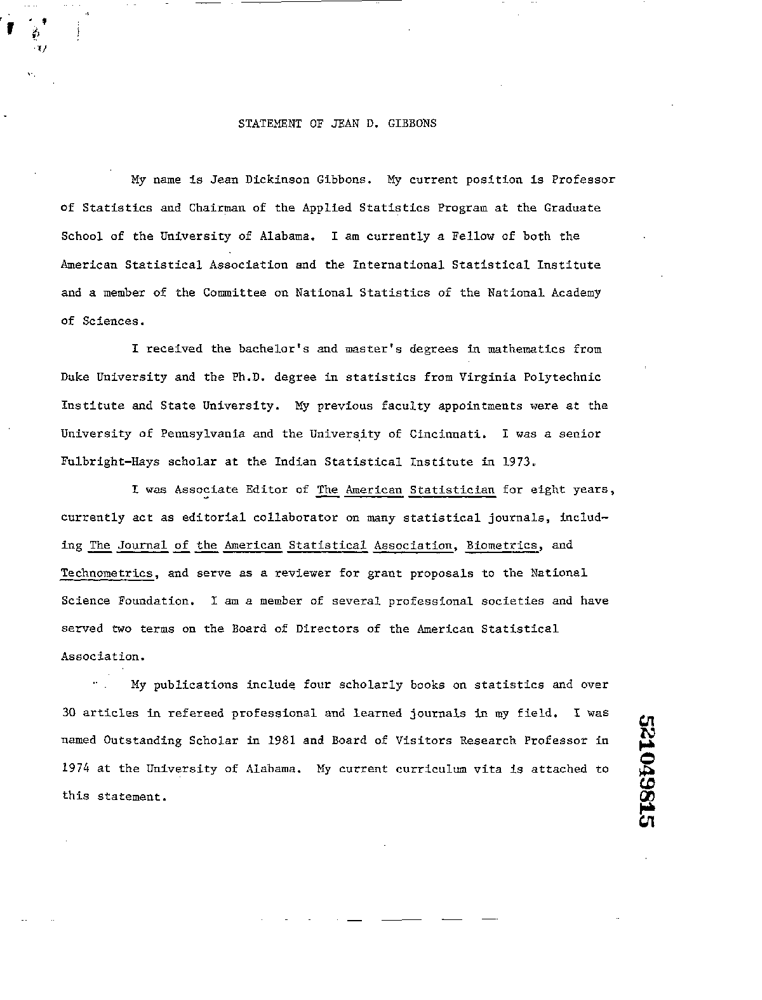

In [6]:
from PIL import Image, ImageDraw, ImageFont

image = Image.open("/content/RVL_CDIP_one_example_per_class/resume/0000157402.tif")
image = image.convert("RGB")
image

We can use the Tesseract OCR engine to turn the image into a list of recognized words:

In [7]:
import pytesseract
import numpy as np

ocr_df = pytesseract.image_to_data(image, output_type='data.frame')
ocr_df = ocr_df.dropna().reset_index(drop=True)
float_cols = ocr_df.select_dtypes('float').columns
ocr_df[float_cols] = ocr_df[float_cols].round(0).astype(int)
ocr_df = ocr_df.replace(r'^\s*$', np.nan, regex=True)
words = ' '.join([word for word in ocr_df.text if str(word) != 'nan'])
words

"ot uv STATEMENT OF JEAN D, GIBBONS My name 4s Jean Dickinson Gibbons. My current position is Professor of Statistics and Chairman of the Applied Statistics Program at the Graduate School of the University of Alabana, I am currently a Fellow of both the American Statistical Association and the International Statistical Institute and a menber of the Committee on National Statistics of the National, Acadeny of Scdences. I received the bachelor's and master's degrees in mathematics from Duke University and the Ph.D. degree in statistics from Virginia Polytechnic Institute and State University. My previous faculty appointments were at the University of Pennsylvania and the University of Cincinnati. I was a senior Fulbright-Hays scholar at the Indian Statistical Institute in 1973. Twas Associate Editor of The Anertcan Statistician for eight years, currently act as editortal collaborator on many statistical journals, includ~ Technometrics, and serve as a reviewer for grant proposals to the N

However, we can use `LayoutLMv2Processor` to easily prepare the data for the model. We give a document image as input to the processor, and it will create `input_ids`, `attention_mask`, `token_type_ids` and `bbox` for us. Internally, it will apply PyTesseract to get the words and bounding boxes, it will normalize the bounding boxes according to the size of the image, and it will turn everything into token-level inputs. It will also resize the document image to 224x224, as the model also requires an `image` input. Handy, isn't it?

Btw, if you prefer to use your own OCR engine, you still can. In that case, you can provide your own words and (normalized) bounding boxes to the processor.

In [8]:
from transformers import LayoutLMv2FeatureExtractor, LayoutLMv2Tokenizer, LayoutLMv2Processor

feature_extractor = LayoutLMv2FeatureExtractor()
tokenizer = LayoutLMv2Tokenizer.from_pretrained("microsoft/layoutlmv2-base-uncased")
processor = LayoutLMv2Processor(feature_extractor, tokenizer)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/707 [00:00<?, ?B/s]

In [9]:
encoded_inputs = processor(image, return_tensors="pt")

In [10]:
for k,v in encoded_inputs.items():
  print(k, v.shape)

input_ids torch.Size([1, 286])
bbox torch.Size([1, 286, 4])
token_type_ids torch.Size([1, 286])
attention_mask torch.Size([1, 286])
image torch.Size([1, 3, 224, 224])


Let's check whether the `input_ids` are created correctly by decoding them back to text:

In [11]:
processor.tokenizer.decode(encoded_inputs.input_ids.squeeze().tolist())

"[CLS] ot uv statement of jean d, gibbons my name 4s jean dickinson gibbons. my current position is professor of statistics and chairman of the applied statistics program at the graduate school of the university of alabana, i am currently a fellow of both the american statistical association and the international statistical institute and a menber of the committee on national statistics of the national, acadeny of scdences. i received the bachelor's and master's degrees in mathematics from duke university and the ph. d. degree in statistics from virginia polytechnic institute and state university. my previous faculty appointments were at the university of pennsylvania and the university of cincinnati. i was a senior fulbright - hays scholar at the indian statistical institute in 1973. twas associate editor of the anertcan statistician for eight years, currently act as editortal collaborator on many statistical journals, includ ~ technometrics, and serve as a reviewer for grant proposal

Note that it also adds the special tokens ([CLS] and [SEP]). You can also pad to a max length, truncate, etc., just like you would do with a regular tokenizer.

## Preprocessing the data using 🤗 datasets

First, we convert the dataset into a Pandas dataframe, having 2 columns: image_path and label.

In [12]:
import pandas as pd
import os

dataset_path = "/content/RVL_CDIP_one_example_per_class"
labels = [label for label in os.listdir(dataset_path)]
id2label = {v: k for v, k in enumerate(labels)}
label2id = {k: v for v, k in enumerate(labels)}
label2id

{'advertisement': 12,
 'budget': 0,
 'email': 8,
 'file_folder': 10,
 'form': 6,
 'invoice': 11,
 'letter': 3,
 'memo': 7,
 'news_article': 9,
 'presentation': 4,
 'questionnaire': 5,
 'resume': 14,
 'scientific_publication': 13,
 'scientific_report': 1,
 'specification': 2}

In [13]:
images = []
labels = []

for label_folder, _, file_names in os.walk(dataset_path):
  if label_folder != dataset_path:
    label = label_folder[40:]
    for _, _, image_names in os.walk(label_folder):
      relative_image_names = []
      for image_file in image_names:
        relative_image_names.append(dataset_path + "/" + label + "/" + image_file)
      images.extend(relative_image_names)
      labels.extend([label] * len (relative_image_names)) 

data = pd.DataFrame.from_dict({'image_path': images, 'label': labels})
data.head()

,image_path,label
0,/content/RVL_CDIP_one_example_per_class/budget...,budget
1,/content/RVL_CDIP_one_example_per_class/scient...,scientific_report
2,/content/RVL_CDIP_one_example_per_class/specif...,specification
3,/content/RVL_CDIP_one_example_per_class/letter...,letter
4,/content/RVL_CDIP_one_example_per_class/presen...,presentation


In [14]:
from datasets import Dataset 

# read dataframe as HuggingFace Datasets object
dataset = Dataset.from_pandas(data)

In [15]:
dataset

Dataset({
    features: ['image_path', 'label'],
    num_rows: 15
})

In [16]:
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D

# we need to define custom features
features = Features({
    'image': Array3D(dtype="int64", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'token_type_ids': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': ClassLabel(num_classes=len(labels), names=labels),
})

def preprocess_data(examples):
  # take a batch of images
  images = [Image.open(path).convert("RGB") for path in examples['image_path']]
  
  encoded_inputs = processor(images, padding="max_length", truncation=True)
  
  # add labels
  encoded_inputs["labels"] = [label2id[label] for label in examples["label"]]

  return encoded_inputs

encoded_dataset = dataset.map(preprocess_data, remove_columns=dataset.column_names, features=features, 
                              batched=True, batch_size=2)

  0%|          | 0/8 [00:00<?, ?ba/s]

Next, we set the format to PyTorch tensors. We also specify to put everything on the GPU (CUDA).

In [17]:
encoded_dataset.set_format(type="torch", device="cuda")

We can create a PyTorch dataloader now:

In [18]:
import torch

dataloader = torch.utils.data.DataLoader(encoded_dataset, batch_size=4)
batch = next(iter(dataloader))

In [19]:
for k,v in batch.items():
  print(k, v.shape)

image torch.Size([4, 3, 224, 224])
input_ids torch.Size([4, 512])
attention_mask torch.Size([4, 512])
token_type_ids torch.Size([4, 512])
bbox torch.Size([4, 512, 4])
labels torch.Size([4])


In [20]:
processor.tokenizer.decode(batch['input_ids'][0].tolist())

'[CLS] the tobacco institute check request vendor # date : december 18, 1995 ‘ amount : $ 461. 86 pay to : datatimes p. o. box 99733 ‘ oklahoma city, ok 73199 explanation : invoice for one month of coverage. distribution of charges project code 1099 or use tax amount $ 461. 86 $ 461. 86 requested by : approyed by : laisac spe mail check to vendor : yes return check to : n / a specify date check is to be mailed : by 12 / 29 / 95 ‘ you must fill - in the requested by and approved by fields before you send this form to accounting confidential : tobacco litigation ‘ r1ok 0000337 [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

In [21]:
id2label[batch['labels'][0].item()]

'budget'

## Define the model

Here we define the model, namely `LayoutLMv2ForSequenceClassification`. We initialize it with the weights of the pre-trained base model (`LayoutLMModel`). The weights of the classification head are randomly initialized, and will be fine-tuned together with the weights of the base model on our tiny dataset. Once loaded, we move it to the GPU.

In [22]:
from transformers import LayoutLMv2ForSequenceClassification
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LayoutLMv2ForSequenceClassification.from_pretrained("microsoft/layoutlmv2-base-uncased", 
                                                            num_labels=len(labels))
model.to(device)

Downloading:   0%|          | 0.00/802M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/layoutlmv2-base-uncased were not used when initializing LayoutLMv2ForSequenceClassification: ['layoutlmv2.visual.backbone.bottom_up.res3.0.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.17.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res2.2.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res2.0.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.7.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.16.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.1.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res3.1.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.18.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.13.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.3.conv3.norm.num_batches_trac

LayoutLMv2ForSequenceClassification(
  (layoutlmv2): LayoutLMv2Model(
    (embeddings): LayoutLMv2Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (x_position_embeddings): Embedding(1024, 128)
      (y_position_embeddings): Embedding(1024, 128)
      (h_position_embeddings): Embedding(1024, 128)
      (w_position_embeddings): Embedding(1024, 128)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (visual): LayoutLMv2VisualBackbone(
      (backbone): FPN(
        (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
        (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
        (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

## Train the model

Here we train the model in familiar PyTorch fashion. We use the Adam optimizer with weight decay fix (normally you can also specify which variables should have weight decay and which not + a learning rate scheduler, see here for how the authors of LayoutLM did this), and train for 30 epochs. If the model is able to overfit it, then it means there are no issues and we can train it on the entire dataset.

In [23]:
from transformers import AdamW
from tqdm.notebook import tqdm

optimizer = AdamW(model.parameters(), lr=5e-5)

global_step = 0
num_train_epochs = 10
t_total = len(dataloader) * num_train_epochs # total number of training steps 

#put the model in training mode
model.train()
for epoch in range(num_train_epochs):
  print("Epoch:", epoch)
  running_loss = 0.0
  correct = 0
  for batch in tqdm(dataloader):
      # forward pass
      outputs = model(**batch)
      loss = outputs.loss

      running_loss += loss.item()
      predictions = outputs.logits.argmax(-1)
      correct += (predictions == batch['labels']).float().sum()

      # backward pass to get the gradients 
      loss.backward()

      # update
      optimizer.step()
      optimizer.zero_grad()
      global_step += 1
  
  print("Loss:", running_loss / batch["input_ids"].shape[0])
  accuracy = 100 * correct / len(data)
  print("Training accuracy:", accuracy.item())

Epoch: 0


  0%|          | 0/4 [00:00<?, ?it/s]

Loss: 3.9261969725290933
Training accuracy: 0.0
Epoch: 1


  0%|          | 0/4 [00:00<?, ?it/s]

Loss: 3.4952540397644043
Training accuracy: 20.000001907348633
Epoch: 2


  0%|          | 0/4 [00:00<?, ?it/s]

Loss: 3.200271209081014
Training accuracy: 40.000003814697266
Epoch: 3


  0%|          | 0/4 [00:00<?, ?it/s]

Loss: 2.867506663004557
Training accuracy: 66.66667175292969
Epoch: 4


  0%|          | 0/4 [00:00<?, ?it/s]

Loss: 2.77290674050649
Training accuracy: 66.66667175292969
Epoch: 5


  0%|          | 0/4 [00:00<?, ?it/s]

Loss: 2.384514490763346
Training accuracy: 93.33333587646484
Epoch: 6


  0%|          | 0/4 [00:00<?, ?it/s]

Loss: 1.9513905843098958
Training accuracy: 100.00000762939453
Epoch: 7


  0%|          | 0/4 [00:00<?, ?it/s]

Loss: 1.6512147188186646
Training accuracy: 100.00000762939453
Epoch: 8


  0%|          | 0/4 [00:00<?, ?it/s]

Loss: 1.3799012104670207
Training accuracy: 100.00000762939453
Epoch: 9


  0%|          | 0/4 [00:00<?, ?it/s]

Loss: 1.0821181138356526
Training accuracy: 100.00000762939453


## Inference

To perform inference on a new document image, 3 things need to be done:

1. prepare the image for the model using `LayoutLMv2Processor`
2. forward pass through the model
3. convert the output of the model to an actual label name

Let's take the first image of the training dataset as an example.

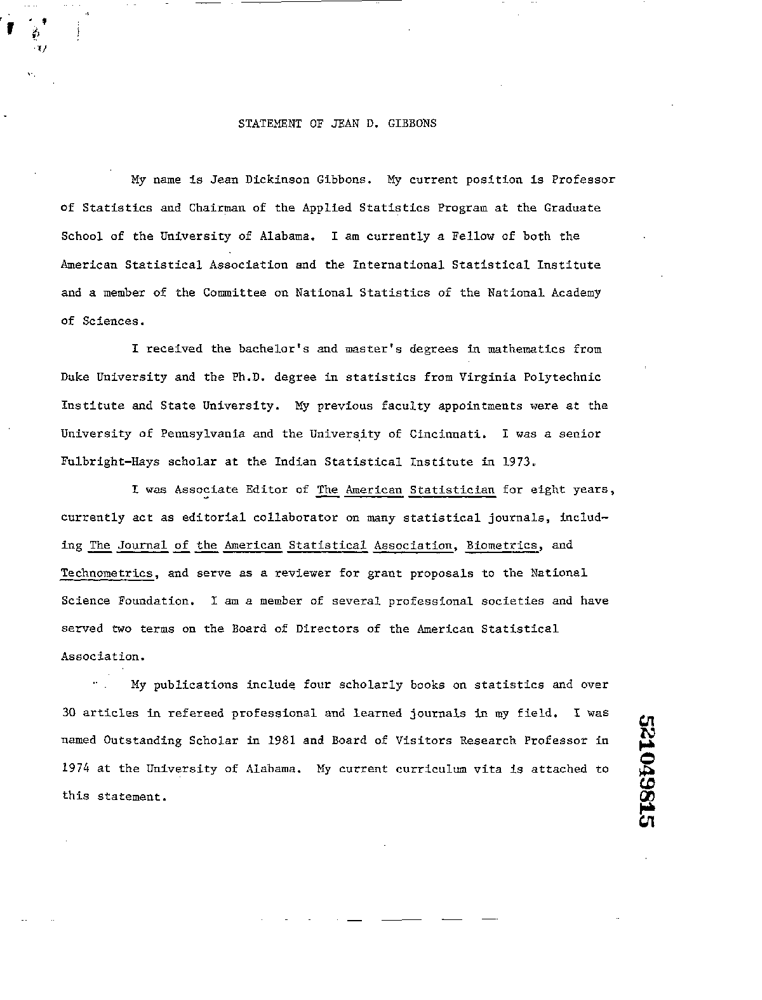

In [24]:
image

In [25]:
# prepare image for the model
encoded_inputs = processor(image, return_tensors="pt")

# make sure all keys of encoded_inputs are on the same device as the model
for k,v in encoded_inputs.items():
  encoded_inputs[k] = v.to(model.device)

# forward pass
outputs = model(**encoded_inputs)

The model outputs `logits` of shape (batch_size, num_labels):

In [26]:
logits = outputs.logits
print(logits.shape)

torch.Size([1, 15])


We simply take the largest logit (i.e. `argmax` on the last dimension), and convert it back to a string using the `id2label` dictionary we created earlier.

In [27]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", id2label[predicted_class_idx])

Predicted class: resume
